In [ ]:
# first I'll clac intersecting groups, then for all the groups I'll make the HR-HR plot

In [18]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRGroups, calcIntersectionOfMultipleGroups, getHRsForTimePeriods, graphMultiHRDate
import pandas as pd


In [ ]:
appleHRDf = getWorkingHRDfParquet('apple')
polarHRDf = getWorkingHRDfParquet('polar')
fitbitHRDf = getWorkingHRDfParquet('fitbit')

In [3]:
#let's look at times that have samples 10 seconds or less apart
appleGroups = getHRGroups(appleHRDf, 10)
print(len(appleGroups))
polarGroups = getHRGroups(polarHRDf, 10)
print(len(polarGroups))
#fitbit takes like a minute to process
fitbitGroups = getHRGroups(fitbitHRDf, 10)
print(len(fitbitGroups))

3134
3134
3134


In [37]:
appleGroups

[[Timestamp('2021-07-19 20:04:01-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-19 22:08:28-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('2021-07-19 22:12:27-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-20 00:38:38-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('2021-07-20 00:43:41-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-20 12:58:50-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('2021-07-20 13:02:31-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-20 16:20:50-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('2021-07-20 16:23:39-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-20 22:57:48-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('2021-07-20 23:08:05-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-21 00:47:58-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('2021-07-21 00:58:31-0700', tz='pytz.FixedOffset(-420)'),
  Timestamp('2021-07-21 15:18:20-0700', tz='pytz.FixedOffset(-420)')],
 [Timestamp('

In [33]:
intersectingGroups = pd.DataFrame(calcIntersectionOfMultipleGroups([appleGroups, fitbitGroups]), columns = ['startDate', 'endDate'])
print(len(intersectingGroups))


4895


In [34]:
intersectingFitbitHRs = getHRsForTimePeriods(intersectingGroups, fitbitHRDf)
intersectingAppleHRs = getHRsForTimePeriods(intersectingGroups, appleHRDf)


In [35]:
print(len(intersectingFitbitHRs))
print(len(intersectingAppleHRs))


804464
38071


In [28]:
sorted(list(set(intersectingFitbitHRs.index.date)))

[datetime.date(2021, 7, 19),
 datetime.date(2021, 7, 20),
 datetime.date(2021, 7, 21),
 datetime.date(2021, 7, 22),
 datetime.date(2021, 7, 23),
 datetime.date(2021, 7, 24),
 datetime.date(2021, 7, 25),
 datetime.date(2021, 7, 26),
 datetime.date(2021, 7, 27),
 datetime.date(2021, 7, 28),
 datetime.date(2021, 7, 29),
 datetime.date(2021, 7, 30),
 datetime.date(2021, 7, 31),
 datetime.date(2021, 8, 1),
 datetime.date(2021, 8, 2),
 datetime.date(2021, 8, 3),
 datetime.date(2021, 8, 4),
 datetime.date(2021, 8, 5),
 datetime.date(2021, 8, 6),
 datetime.date(2021, 8, 7),
 datetime.date(2021, 8, 8),
 datetime.date(2021, 8, 9),
 datetime.date(2021, 8, 10),
 datetime.date(2021, 8, 11),
 datetime.date(2021, 8, 12),
 datetime.date(2021, 8, 13),
 datetime.date(2021, 8, 14),
 datetime.date(2021, 8, 15),
 datetime.date(2021, 8, 16),
 datetime.date(2021, 8, 17),
 datetime.date(2021, 8, 18),
 datetime.date(2021, 8, 19),
 datetime.date(2021, 8, 20),
 datetime.date(2021, 8, 21),
 datetime.date(2021, 8,

/home/chowder/Documents/dataImport/utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 1083 samples for fitbit in 2 groups


/home/chowder/Documents/dataImport/utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 471 samples for apple in 1 groups


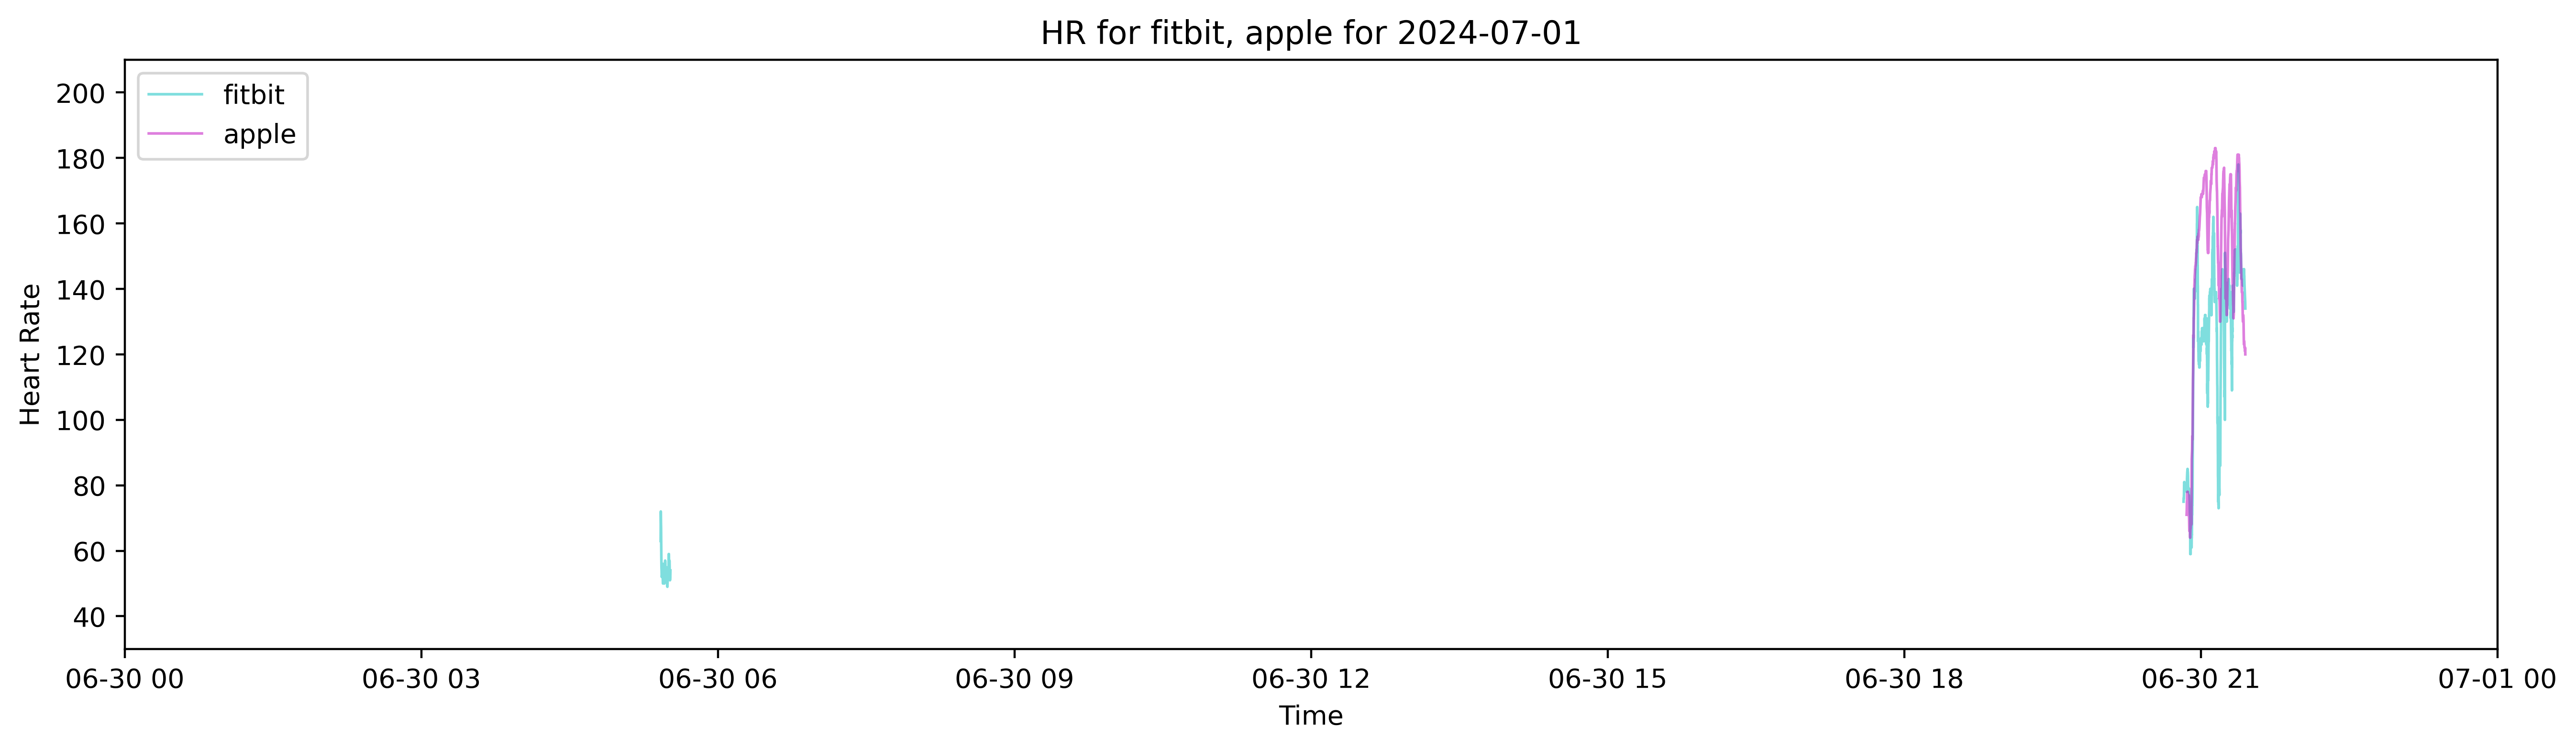

In [36]:
from datetime import date, time
graphMultiHRDate([intersectingFitbitHRs, intersectingAppleHRs], date(2024,7,1), ['fitbit','apple'], time(0,0,0))